In [1]:
import pandas as pd
import csv

c:\programdata\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\programdata\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


In [5]:
dataset = pd.read_csv('regression_dataset.csv', sep=";")

In [6]:
dataset

,Unnamed: 0,contract,district,renting_type,surface,locals,floor,property_type,price,spese condominio,other_expences,building_year,status,heating,air_conditioning,energy_certificate,parking_slots,heating_expences,heating_system,announce_link
0,0,Affitto,aurora,Intera proprietà,70,3,2°,Intera proprietà,450,50.0,NaN,1900.0,buono/abitabile,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/83690507/
1,1,Affitto,aurora,Intera proprietà,35,1,4°,Intera proprietà,300,20.0,NaN,NaN,buono/abitabile,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/83691709/
2,2,Affitto,aurora,Intera proprietà,65,2,2°,Intera proprietà,650,NaN,NaN,NaN,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,centralizzato,https://www.immobiliare.it/annunci/83685327/
3,3,Affitto,aurora,Intera proprietà,30,1,3°,Intera proprietà,340,NaN,NaN,NaN,buono/abitabile,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/83681637/
4,4,Affitto,aurora,Intera proprietà,50,2,4°,Intera proprietà,450,NaN,NaN,1940.0,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,centralizzato,https://www.immobiliare.it/annunci/83652291/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5056,5056,Affitto,mirafiori-nord,Intera proprietà,70,3,6°,Intera proprietà,500,50.0,NaN,1965.0,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,centralizzato,https://www.immobiliare.it/annunci/76983100/
5057,5057,Affitto,mirafiori-nord,Intera proprietà,70,3,3°,Intera proprietà,700,50.0,NaN,NaN,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/62283184/.1
5058,5058,Affitto,mirafiori-nord,Intera proprietà,120,4,2°,Intera proprietà,650,110.0,NaN,NaN,buono/abitabile,NaN,None,NaN,NaN,NaN,centralizzato,https://www.immobiliare.it/annunci/52358861/
5059,5059,Affitto,mirafiori-nord,Intera proprietà,100,4,4°,Parziale proprietà,Prezzo su richiesta,33.0,NaN,1958.0,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,centralizzato,https://www.immobiliare.it/annunci/44978706/.1


In [7]:
dataset.drop(columns='renting_type', inplace=True)

In [8]:
dataset.dtypes

Unnamed: 0              int64
contract               object
district               object
surface                object
locals                 object
floor                  object
property_type          object
price                  object
spese condominio      float64
other_expences        float64
building_year         float64
status                 object
heating               float64
air_conditioning       object
energy_certificate    float64
parking_slots         float64
heating_expences      float64
heating_system         object
announce_link          object
dtype: object

In [12]:
#dataset.drop(columns='Unnamed: 0', inplace=True)
dataset.replace('5+', 6, inplace = True)
dataset.replace('3+', 4, inplace = True)
dataset = dataset[dataset.price != 'Affitto\n                                                                                    750/mese\n                                        ']
dataset = dataset[dataset.price != 'Affitto\n                                                                                    500/mese\n                                        ']
dataset = dataset[dataset.locals != 'C']
dataset = dataset[dataset.price != 'prezzo su richiesta']
dataset = dataset[dataset.surface != '250, terreno di proprietà 2.000']
dataset = dataset[dataset.surface != '100, terreno di proprietà 200']
dataset = dataset[dataset.surface != '160, terreno di proprietà 400']
dataset = dataset[dataset.surface != '165, terreno di proprietà 450']
dataset = dataset[dataset.surface != '105, terreno di proprietà 100']
dataset = dataset[dataset.surface != '130, terreno di proprietà 180']
dataset = dataset[dataset.price != 'Affitto\n                                                                                    450/mese\n                                        ']
dataset = dataset[dataset.locals != 'c']

In [13]:
dataset.fillna(value=0, inplace=True)

In [14]:
dataset.to_csv('before_regression.csv', sep=';')

## 
## PYCARET

In [15]:
from pycaret.regression import *
import pandas as pd

In [20]:
dataset = pd.read_csv('before_regression.csv', sep=";")
dataset = dataset[dataset['price']!='Prezzo su richiesta']
dataset.drop(columns='Unnamed: 0', inplace=True)
dataset.fillna(0, inplace=True)

metri = []

for elem in dataset['surface']:
    if len(elem)>3:
        metri.append(elem[0:3])
    else:
        metri.append(elem)
        
dataset['surface'] = metri
dataset['price'] = dataset['price'].astype(int)
#dataset['Price'] = (dataset['Prezzo'].astype(int) + dataset['Spese condominio'].astype(int) + dataset['Spese riscaldamento'].astype(int))
dataset['locals'] = dataset['locals'].astype(int)
dataset['surface'] = dataset['surface'].astype(int)
dataset = dataset[dataset['price']<1000]
dataset.to_csv('dataset_lower_then_1000.csv', sep=';')
dati = dataset.drop(columns= ['spese condominio', 'heating_expences', 'other_expences', 'energy_certificate'])

In [40]:
exp_reg101 = setup(data = dati.drop(columns=['announce_link', 'Unnamed: 0.1']), target = 'price', categorical_features = ['contract', 'district', 'floor', 'property_type', 'building_year', 'air_conditioning'], numeric_features=['locals','surface'], remove_outliers= True) 

,Description,Value
0,session_id,3428
1,Target,price
2,Original Data,"(4358, 13)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2897, 125)"


In [41]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,83.5572,12945.3929,113.5217,0.5561,0.2914,0.1670,0.1710
rf,Random Forest Regressor,82.4275,13139.6637,114.3854,0.5491,0.2208,0.1641,0.6220
br,Bayesian Ridge,86.3371,14268.3487,119.0001,0.5121,0.3175,0.1753,0.0680
ridge,Ridge Regression,86.2968,14353.9100,119.3497,0.5093,0.2843,0.1759,0.0200
huber,Huber Regressor,85.0384,14511.0213,119.8347,0.5037,0.3017,0.1719,0.3570
lr,Linear Regression,86.7664,14531.7601,120.0786,0.5032,0.2811,0.1769,0.5330
et,Extra Trees Regressor,86.4399,14771.0179,121.2174,0.4949,0.2374,0.1709,0.8530
omp,Orthogonal Matching Pursuit,89.2966,14850.3566,121.4580,0.4917,0.2715,0.1822,0.0200
lasso,Lasso Regression,88.8201,14915.8818,121.6633,0.4898,0.3407,0.1793,0.0230
knn,K Neighbors Regressor,91.5595,15302.8732,123.4271,0.4760,0.2471,0.1829,0.0580


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=3428, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
model = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,80.8951,12334.1671,111.0593,0.5787,0.2089,0.1632
1,80.4050,12394.5120,111.3306,0.5709,0.2051,0.1540
2,83.1718,12297.5467,110.8943,0.5874,0.2064,0.1644
3,86.0689,15860.1763,125.9372,0.5306,0.2319,0.1732
4,80.3636,10894.5183,104.3768,0.6135,0.1921,0.1620
5,85.3228,14525.5971,120.5222,0.4019,0.2282,0.1728
6,81.4412,13290.0909,115.2827,0.5401,0.2318,0.1771
7,86.2891,14453.2094,120.2215,0.5195,0.2225,0.1722
8,87.5232,14956.2205,122.2956,0.5479,0.3059,0.1705
9,72.7944,10390.5983,101.9343,0.6008,0.1750,0.1314


In [43]:
tuned_model = tune_model(model, n_iter = 4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,83.7272,12414.8472,111.4219,0.5759,0.2140,0.1720
1,95.4868,16148.0369,127.0749,0.4410,0.2312,0.1823
2,88.2132,13185.8873,114.8298,0.5576,0.2140,0.1745
3,94.4564,17521.0701,132.3672,0.4814,0.2474,0.1934
4,84.0803,11812.1309,108.6836,0.5809,0.2046,0.1718
5,91.6711,15905.1659,126.1157,0.3451,0.2389,0.1855
6,91.2642,15449.3302,124.2953,0.4654,0.2459,0.1953
7,92.0610,15201.1024,123.2928,0.4947,0.2260,0.1836
8,92.1695,15423.9976,124.1934,0.5338,0.2234,0.1784
9,83.4225,12670.8107,112.5647,0.5132,0.1967,0.1548


In [44]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [45]:
predict_model(tuned_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,86.6216,13389.5636,115.7133,0.5225,0.2664,0.5377


In [46]:
final_model = finalize_model(tuned_model)
print(final_model)
predict_model(final_model);

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.005,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=240, n_jobs=-1, oob_score=False,
                      random_state=3428, verbose=0, warm_start=False)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,81.3217,11904.5906,109.1082,0.5754,0.2556,0.4861


In [47]:
save_model(final_model,'Final Model 12112020')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['contract',
                                                             'district', 'floor',
                                                             'property_type',
                                                             'building_year',
                                                             'air_conditioning'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['locals', 'surface'],
                                       target='price', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical...
                  RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                        criterion='mse', max_depth=6,
                       

In [48]:
predictions = predict_model(final_model, data=dati.drop(columns=['announce_link', 'Unnamed: 0.1']))

In [49]:
predictions.reset_index(inplace=True)

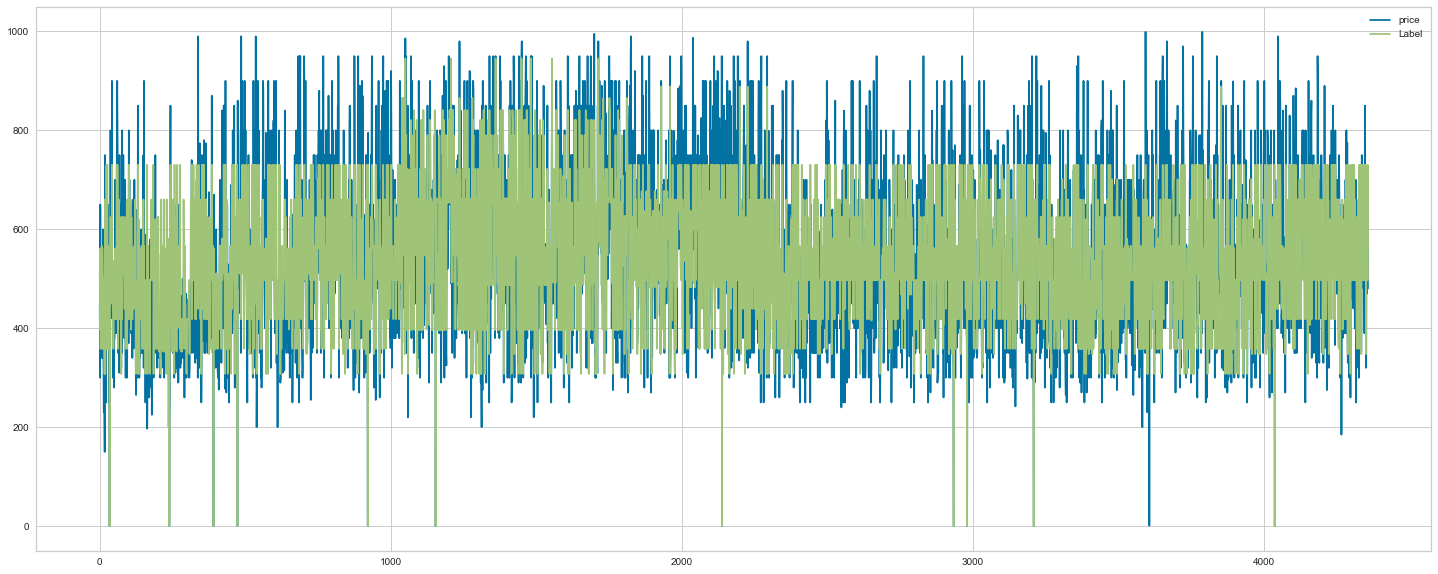

In [50]:
predictions = predictions[predictions['price']<3000]
plt = predictions[['price', 'Label']].plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig("risultato_pycaret.png")
fig.savefig("risultato_pycaret.svg")

<AxesSubplot:>

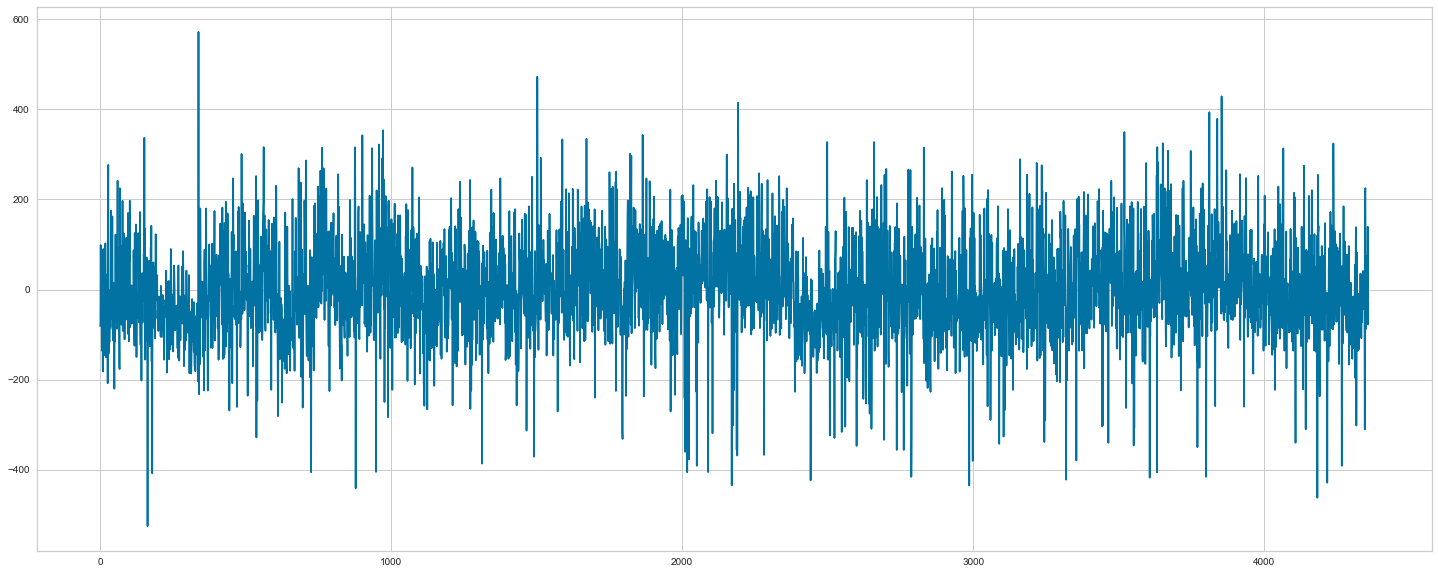

In [37]:
(predictions['price'] - predictions['Label']).plot(figsize=(25,10))

In [51]:
predictions['links'] = dati.reset_index()['announce_link']

In [52]:
predictions.to_csv('predictions_PYCARET.csv')